Задание

![image.png](pictures/lab0.jpg)

Download plugin jupyter

In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

In [ ]:
!/content/src/my_curand

In [ ]:
!git clone https://github.com/Microsoft/vcpkg.git
!cd vcpkg
!./bootstrap-vcpkg.sh
!./vcpkg integrate install
!vcpkg install matplotlib-cpp

In [ ]:
!sudo apt install qtbase5-dev git cmake build-essential

In [ ]:
!nvcc -o /content/src/my_curand /content/src/my_curand.cu -lcurand

Load the plugin

In [9]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


Вычисления на CPU

Информация о CPU

In [10]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.132
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

CPU с двумя ядрами

In [11]:
!cat /proc/cpuinfo | grep 'core id'

core id		: 0
core id		: 0


In [15]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <iostream>
#include <vector>
#include <algorithm>
#include <limits>
#include <random>
#include <time.h>
#include <chrono>
#include <ctime>
#include <vector>
#include <cmath>
#include <fstream>

using namespace std;

void print(vector<vector<int>> matrix, int num_rows){
    for (auto i = 0u; i < num_rows; ++i)
    {
        std::vector<int> myVector = matrix[i];
        std::cout << "(row " << i << "): ";
        for (auto v: myVector)
        {
            std::cout << v << ",";
        }
        std::cout << "\n";
    }
}

static std::vector<int> generate_data(size_t size, int amplitude)
{
    using value_type = int;
    static std::uniform_int_distribution<value_type> distribution(0, amplitude);
    static std::default_random_engine generator;

    std::vector<value_type> data(size);
    std::generate(data.begin(), data.end(), []() { return distribution(generator); });
    return data;
}

vector<vector<int>> generate_matrix(int num_rows, int amplitude){
    vector<vector<int>> mat(num_rows);
    for (int i = 0; i < num_rows; i++) {
       mat[i] = generate_data(num_rows, amplitude);
      }

    return mat;
}

vector<vector<int>> multiple_matrices(int num_rows,
                                      vector<vector<int>> A,
                                      vector<vector<int>> B){
    vector<vector<int>> result = generate_matrix(num_rows, 0);

    for(int i = 0; i < num_rows; i++){
        for(int j = 0; j < num_rows; j++){
            for(int k = 0; k < num_rows; k++){
                result[i][j] = A[i][k] + B[k][j];
            }
        }
    }
    return result;
}

int main()
{
    int num_rows;
    unsigned int start_time;
    unsigned int end_time;
    unsigned int search_time;
    vector<vector<int>> A;
    vector<vector<int>> B;
    vector<vector<int>> result;

    vector<double> times;
    vector<int> matrix_sizes;

    int j = 5;
    for(int i = 1; i < j; i++){
      num_rows = 500*i;
      A = generate_matrix(num_rows, 10);
      B = generate_matrix(num_rows, 10);

      start_time =  clock();
      result = multiple_matrices(num_rows, A, B);
      end_time = clock();
      search_time = end_time - start_time;

      std::cout << "The time: " << (double) search_time / CLOCKS_PER_SEC << "s ";
      std::cout << "Matrix size: " << num_rows << "x" << num_rows;
      std::cout << "\n";

      times.push_back((double) search_time / CLOCKS_PER_SEC);
      matrix_sizes.push_back(num_rows);
    }

    std::ofstream out("data.txt");
    if (out.is_open()){
        for (int i = 0; i < j - 1; i++){
            cout << i;
            out << matrix_sizes[i] << " " << times[i] << "\n";
        }
    }
    out.close();

    return 0;
}

The time: 2.29483s Matrix size: 500x500
The time: 25.6252s Matrix size: 1000x1000
The time: 94.022s Matrix size: 1500x1500
The time: 253.277s Matrix size: 2000x2000
0123


In [16]:
f = open("data.txt", "r")
times = []
sizes = []

for l in f:
  size, time = l.split(" ")
  times.append(time)
  sizes.append(size)

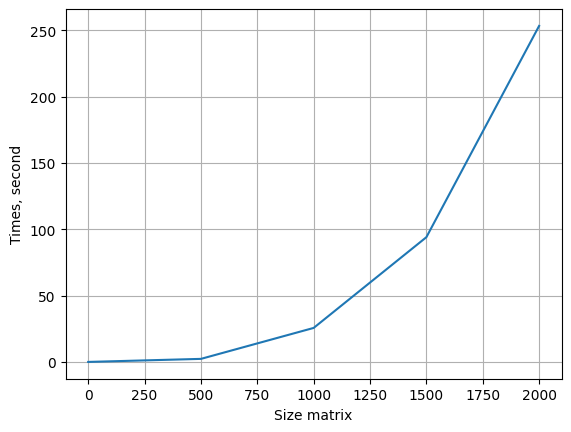

In [87]:
import matplotlib.pyplot as plt

sizes = [500, 1000, 1500, 2000]
times = [2.29483, 25.6252, 94.022, 253.277]

plt.plot([0] + sizes, [0] + times)
plt.xlabel("Size matrix")
plt.ylabel("Times, second")
plt.grid()
plt.show()

Вычисления на GPU

Информация о GPU

In [16]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!sudo apt update

In [ ]:
!sudo apt install lshw

In [25]:
!sudo lshw -class display

  *-display
       description: 3D controller
       product: TU104GL [Tesla T4]
       vendor: NVIDIA Corporation
       physical id: 4
       bus info: pci@0000:00:04.0
       version: a1
       width: 64 bits
       clock: 33MHz
       capabilities: msix pm bus_master cap_list
       configuration: driver=nvidia latency=0
       resources: iomemory:30-2f iomemory:30-2f irq:11 memory:c0000000-c0ffffff memory:380000000-38fffffff memory:390000000-391ffffff


In [29]:
%%cu

#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>
#include <stdlib.h>

using namespace std;

int main() {
  int nDevices;
  cudaGetDeviceCount(&nDevices);

  printf("Number of devices: %d\n", nDevices);

  for (int i = 0; i < nDevices; i++) {
    cudaDeviceProp prop;
    cudaGetDeviceProperties(&prop, i);
    printf("Device Number: %d\n", i);
    printf("  Device name: %s\n", prop.name);
    printf("  Memory Clock Rate (MHz): %d\n",
           prop.memoryClockRate/1024);
    printf("  Memory Bus Width (bits): %d\n",
           prop.memoryBusWidth);
    printf("  Peak Memory Bandwidth (GB/s): %.1f\n",
           2.0*prop.memoryClockRate*(prop.memoryBusWidth/8)/1.0e6);
    printf("  Total global memory (Gbytes) %.1f\n",(float)(prop.totalGlobalMem)/1024.0/1024.0/1024.0);
    printf("  Shared memory per block (Kbytes) %.1f\n",(float)(prop.sharedMemPerBlock)/1024.0);
    printf("  minor-major: %d-%d\n", prop.minor, prop.major);
    printf("  Warp-size: %d\n", prop.warpSize);
    printf("  Concurrent kernels: %s\n", prop.concurrentKernels ? "yes" : "no");
    printf("  Concurrent computation/communication: %s\n\n",prop.deviceOverlap ? "yes" : "no");
  }
}

Number of devices: 1
Device Number: 0
  Device name: Tesla T4
  Memory Clock Rate (MHz): 4883
  Memory Bus Width (bits): 256
  Peak Memory Bandwidth (GB/s): 320.1
  Total global memory (Gbytes) 14.7
  Shared memory per block (Kbytes) 48.0
  minor-major: 5-7
  Warp-size: 32
  Concurrent kernels: yes
  Concurrent computation/communication: yes




Произведение квадратных матриц

Было распараллелено вычисление элемента матрицы.
Для этого матрица разбивалась на блоки независимо для каждого ядра, каждое ядро вычисляет соответствующий блок матрицы и сохраняет значение в ячейке результирующей матрицы.

К примеру, одна нить вычисляет результирующий элемент матрицы: res11 = a1k*bk1 и записывает это значение в результирующий матрицу, далее следущая нить вычисляет элемент, и так все происходит параллельно на различных нитях.


За счет этого получаем эффективное параллельное вычисление, по сравнению с вычислением на CPU.





In [45]:
%%cu

#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>
#include <stdlib.h>
#include <vector>
#include <fstream>

#define BLOCK_SIZE 16
#define BASE_TYPE double

using namespace std;

__global__ void matrixMult(const BASE_TYPE *A, const BASE_TYPE *B, BASE_TYPE *C, int N)
{
  // Строчка в матрице
  int i0 = N * (blockDim.y * blockIdx.y + threadIdx.y);
  // Столбец в матрице
  int j0 = blockDim.x * blockIdx.x + threadIdx.x;
  BASE_TYPE sum = 0;

  for (int k = 0; k < N; k++){
     sum += A[i0 + k] * B[k * N + j0];
  }

  int ind = N * (blockDim.y * blockIdx.y + threadIdx.y) + blockDim.x * blockIdx.x + threadIdx.x;
  C[ind] = sum;
}
int toMultiple(int a, int b) {
  int mod = a % b;
  if (mod != 0) {
    mod = b - mod;
    return a + mod;
  }
  return a;
}

int main()
{
  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);
  vector<float> times;
  vector<int> sizes;

  int j = 25;
  for(int i = 1; i < j; i++){
    int N = 500*i;
    sizes.push_back(N);
    // количество строк и столбцов матрицы

    N = toMultiple(N, BLOCK_SIZE);

    size_t Nsize = N * N * sizeof(BASE_TYPE);

    BASE_TYPE *h_A = (BASE_TYPE *)malloc(Nsize);
    BASE_TYPE *h_B = (BASE_TYPE *)malloc(Nsize);
    BASE_TYPE *h_C = (BASE_TYPE *)malloc(Nsize);

    for (int i = 0; i < N * N; ++i) {
      h_A[i] = rand()/(BASE_TYPE)RAND_MAX;
    }
    for (int i = 0; i < N * N; ++i) {
      h_B[i] = rand()/(BASE_TYPE)RAND_MAX;
    }

    BASE_TYPE *d_A = NULL;
    cudaMalloc((void **)&d_A, Nsize);

    BASE_TYPE *d_B = NULL;
    cudaMalloc((void **)&d_B, Nsize);

    BASE_TYPE * d_C = NULL;
    cudaMalloc((void **)&d_C, Nsize);
    cudaMemcpy(d_A, h_A, Nsize, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, Nsize, cudaMemcpyHostToDevice);

    // Размер блока
    dim3 threadsPerBlock = dim3(BLOCK_SIZE, BLOCK_SIZE);
    // Размер сетки
    dim3 blocksPerGrid = dim3(N / BLOCK_SIZE, N / BLOCK_SIZE);

    cudaEventRecord(start, 0);

    matrixMult<<<blocksPerGrid, threadsPerBlock>>>(d_A, d_B, d_C, N);

    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    float KernelTime;
    cudaEventElapsedTime(&KernelTime, start, stop);
    printf("Time: %.2f milliseconds, size matrix: %d \n", KernelTime, 500*i);
    times.push_back((double) KernelTime / 1000.0);

    cudaMemcpy(h_C, d_C, Nsize, cudaMemcpyDeviceToHost);

    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);
    free(h_A);
    free(h_B);
    free(h_C);
  }

  if(cudaDeviceSynchronize() != cudaSuccess) {
    fprintf(stderr, "CUDA Error: %s\n", cudaGetErrorString(cudaPeekAtLastError()));
  }

  ofstream out("data_cuda.txt");
  if (out.is_open()){
      for (int i = 0; i < j - 1; i++){
          out << sizes[i] << " " << times[i] << "\n";
      }
  }
  out.close();
  return 0;
}

Time: 3.04 milliseconds, size matrix: 500 
Time: 22.81 milliseconds, size matrix: 1000 
Time: 75.43 milliseconds, size matrix: 1500 
Time: 172.82 milliseconds, size matrix: 2000 
Time: 160.39 milliseconds, size matrix: 2500 
Time: 259.73 milliseconds, size matrix: 3000 
Time: 417.65 milliseconds, size matrix: 3500 
Time: 623.89 milliseconds, size matrix: 4000 
Time: 930.95 milliseconds, size matrix: 4500 
Time: 1294.88 milliseconds, size matrix: 5000 
Time: 1802.04 milliseconds, size matrix: 5500 
Time: 2283.38 milliseconds, size matrix: 6000 
Time: 2998.48 milliseconds, size matrix: 6500 
Time: 3821.03 milliseconds, size matrix: 7000 
Time: 4678.82 milliseconds, size matrix: 7500 
Time: 5610.93 milliseconds, size matrix: 8000 
Time: 6994.42 milliseconds, size matrix: 8500 
Time: 8294.28 milliseconds, size matrix: 9000 
Time: 9574.15 milliseconds, size matrix: 9500 
Time: 11504.26 milliseconds, size matrix: 10000 
Time: 13603.32 milliseconds, size matrix: 10500 
Time: 15910.37 millisec

In [73]:
f = open("data_cuda.txt", "r")
times_cuda = []
sizes_cuda = []

for l in f:
  size, time = l.split(" ")
  times_cuda.append(time)
  sizes_cuda.append(size)

Получаем линейную зависимость времени от размера матриц. Коллосальную скорость вычисления по сравнению с CPU, так при произведении матриц 2000х2000 на CPU вычисления происходят за 250 секунд, а на GPU 172 миллисекунды.

Прирост скорости вычисления по сравнению с CPU:  34.71900749930562


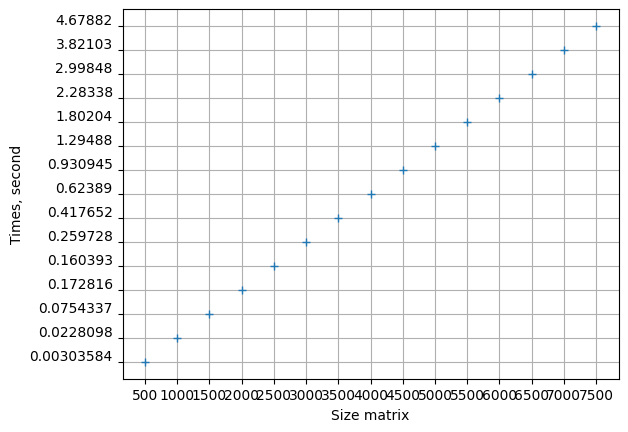

In [86]:
import matplotlib.pyplot as plt

print("Прирост скорости вычисления по сравнению с CPU: ", float(time[3])/float(times_cuda[3]))
plt.plot(sizes_cuda[0:15], times_cuda[0:15], '+')
plt.xlabel("Size matrix")
plt.ylabel("Times, second")
plt.grid()
plt.show()
